In [1]:
import random
from sys import platform
import clr
import numpy as np
import matplotlib.pyplot as plt
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator import SBXCrossover, PolynomialMutation, RandomSolutionSelection
from jmetal.util.termination_criterion import StoppingByKeyboard, StoppingByEvaluations
from jmetal.util.observer import PrintObjectivesObserver, WriteFrontToFileObserver

from jmetal.core.quality_indicator import GenerationalDistance
from jmetal.core.problem import FloatProblem, FloatSolution, OnTheFlyFloatProblem
from jmetal.util.solution import (
    get_non_dominated_solutions,
    print_function_values_to_screen,
    print_variables_to_screen,
)

if platform == "win32":
    import pythoncom

    pythoncom.CoInitialize()
    PATH = "c:\\Users\\volkan.akkaya\\AppData\\Local\\DWSIM8\\"
elif platform == "linux":
    PATH = "/usr/local/lib/dwsim/"
else:
    PATH = "/Applications/DWSIM.app/Contents/MonoBundle/"


clr.AddReference(PATH + "DWSIM.Automation.dll")
clr.AddReference(PATH + "DWSIM.Interfaces.dll")
clr.AddReference(PATH + "DWSIM.UnitOperations.dll")
clr.AddReference(PATH + "DWSIM.FlowsheetSolver.dll")

from DWSIM.Automation import Automation3
#from DWSIM.Interfaces.Enums import PropertyType
#from DWSIM.FlowsheetSolver import FlowsheetSolver

fs = Automation3()
sim = fs.LoadFlowsheet2("DFORC.dwxmz")

def print_properties(uo_name:str):
    global sim
    a = sim.GetFlowsheetSimulationObject(uo_name)
    for p in a.GetProperties(PropertyType.ALL):
        print(f"{p}: {a.GetPropertyValue(p)}")

/Users/volkan/Projects/DWSim-JMetalPY/venv/lib/python3.10/site-packages/clr_loader/mono.py:180: UserWarning: Hosting Mono versions before v6.12 is known to be problematic. If the process crashes shortly after you see this message, try updating Mono to at least v6.12.
  warnings.warn(


In [2]:
class Problem(FloatProblem):
    def __init__(self):
        super(Problem, self).__init__()
        self.number_of_objectives = 1
        self.number_of_variables = 2
        self.number_of_constraints = 1
        self.lower_bound = [100E3, 60E3]
        self.upper_bound = [190E3, 190E3]
        
        
        self.obj_directions=[self.MAXIMIZE]
        self.obj_labels=["CHP efficiecny"]
        
    def evaluate(self, solution: FloatSolution)->FloatSolution:
        inlet = sim.GetFlowsheetSimulationObject("PRODUCTIONWELL")
        valve = sim.GetFlowsheetSimulationObject("VALVE1")
        hpt = sim.GetFlowsheetSimulationObject("HPT")
        lpt = sim.GetFlowsheetSimulationObject("LPT")
        hx =  sim.GetFlowsheetSimulationObject("HEATEXCHANGER")
        condenser =  sim.GetFlowsheetSimulationObject("CONDENSER")
        backwater1 = sim.GetFlowsheetSimulationObject( "BACKWATER1")
        backwater2 = sim.GetFlowsheetSimulationObject("BACKWATER2")
        supply1 = sim.GetFlowsheetSimulationObject("SUPPLY1")
        supply2 = sim.GetFlowsheetSimulationObject("SUPPLY2")
        
        p0 = solution.variables[0]
        p1 = solution.variables[1]
        valve.SetPropertyValue("PROP_VA_2", float(p0))
        hpt.SetPropertyValue("PROP_TU_4", float(p1))
        #fs.CalculateFlowsheet2(sim)
        
        ml = 1
        mu = 300
        mm = 0.5*(ml+mu)
        for i in range(12):
            backwater1.SetPropertyValue("PROP_MS_2", ml)
            fs.CalculateFlowsheet2(sim)
            fl = supply1.GetPropertyValue("PROP_MS_0")-318
            backwater1.SetPropertyValue("PROP_MS_2", mm)
            fs.CalculateFlowsheet2(sim)
            fm = supply1.GetPropertyValue("PROP_MS_0")-318
            if fm*fl<0:
                mu = mm
            else:
                ml = mm
            mm = 0.5*(mu+ml)
            
        ml = 1.0
        mu = 300.0
        mm = 0.5*(ml+mu)
        for i in range(12):
            backwater2.SetPropertyValue("PROP_MS_2", ml)
            fs.CalculateFlowsheet2(sim)
            fl = supply2.GetPropertyValue("PROP_MS_0")-318
            backwater2.SetPropertyValue("PROP_MS_2", mm)
            fs.CalculateFlowsheet2(sim)
            fm = supply2.GetPropertyValue("PROP_MS_0")-318
            if fm*fl<0:
                mu = mm
            else:
                ml = mm
            mm = 0.5*(mu+ml)
        
        qin = abs(inlet.GetPropertyValue("PROP_MS_2")*inlet.GetPropertyValue("PROP_MS_32"))
        
        # thermal
        condenser_efficency = condenser.GetPropertyValue("PROP_HX_25")
        q_condenser = condenser.GetPropertyValue("PROP_HX_2")
        hx_efficency = hx.GetPropertyValue("PROP_HX_25")
        q_hx = hx.GetPropertyValue("PROP_HX_2")
        wth = (q_condenser + q_hx)
        
        # mechanical
        generator_efficiency = 0.95
        mechanical_efficiency = 0.95
        whpt = hpt.GetPropertyValue("PROP_TU_3")
        wlpt = lpt.GetPropertyValue("PROP_TU_3")
        wnet = generator_efficiency*mechanical_efficiency*(whpt+wlpt)
        power_gen_efficiency=wnet/qin
        chp_efficiency = (wth+wnet)/qin
        
        
        solution.objectives = [ -wnet]
        solution.constraints = [p1-p0]
        
        return solution
        
    def create_solution(self)->FloatSolution:
        new_solution = FloatSolution(
        number_of_objectives=self.number_of_objectives,
        number_of_constraints=self.number_of_constraints,
        lower_bound=self.lower_bound,
        upper_bound=self.upper_bound)
        p0 = 100E3+random.random()*(190E3-100E3)
        p1 = 60e3+random.random()*(p0-60e3)
        new_solution.variables =[p0, p1]
        return new_solution
    
    def get_name(self)->str:
        return "DFORC Problem"
    
    

In [3]:
problem = Problem()
algorithm = GeneticAlgorithm(
    problem=problem,
    population_size=20,
    offspring_population_size=20,
    mutation=PolynomialMutation(
        probability=1.0 / problem.number_of_variables, distribution_index=20
    ),
    crossover=SBXCrossover(probability=1.0, distribution_index=20),
    selection=RandomSolutionSelection(),
    termination_criterion=StoppingByEvaluations(max_evaluations=500),
    #termination_criterion=StoppingByKeyboard(),
)
basic = PrintObjectivesObserver()
algorithm.observable.register(basic)


In [4]:
algorithm.run()

2023-03-22 05:07:31,854 [MainThread  ] [INFO ]  Evaluations: 20. fitness: [-118.44120094215693]
2023-03-22 05:08:35,043 [MainThread  ] [INFO ]  Evaluations: 40. fitness: [-131.9757873565638]
2023-03-22 05:09:41,707 [MainThread  ] [INFO ]  Evaluations: 60. fitness: [-132.2002057185563]
2023-03-22 05:10:49,704 [MainThread  ] [INFO ]  Evaluations: 80. fitness: [-132.76882838615353]
2023-03-22 05:11:59,852 [MainThread  ] [INFO ]  Evaluations: 100. fitness: [-132.76882838615353]
2023-03-22 05:13:11,846 [MainThread  ] [INFO ]  Evaluations: 120. fitness: [-132.76882838615353]
2023-03-22 05:14:22,762 [MainThread  ] [INFO ]  Evaluations: 140. fitness: [-132.76882838615353]
2023-03-22 05:15:33,984 [MainThread  ] [INFO ]  Evaluations: 160. fitness: [-132.7693995440492]
2023-03-22 05:16:47,488 [MainThread  ] [INFO ]  Evaluations: 180. fitness: [-132.7693995440492]
2023-03-22 05:18:01,732 [MainThread  ] [INFO ]  Evaluations: 200. fitness: [-132.7693995440492]
2023-03-22 05:19:16,568 [MainThread  ] 

In [22]:
res1 = algorithm.get_result()
print(res1)
algorithm.observable.observers[1].update

Solution(variables=[135443.4290161224, 91136.0026119844],objectives=[-132.7753351400862],constraints=[-44307.426404137994])


<bound method PrintObjectivesObserver.update of <jmetal.util.observer.PrintObjectivesObserver object at 0x14a087760>>

In [10]:
algorithm.run()
res2 = algorithm.get_result()

2022-09-07 00:44:49,671 [MainThread  ] [INFO ]  Evaluations: 20. fitness: [-123.51131903048434]
2022-09-07 00:45:35,801 [MainThread  ] [INFO ]  Evaluations: 40. fitness: [-132.41864490079058]
2022-09-07 00:46:21,713 [MainThread  ] [INFO ]  Evaluations: 60. fitness: [-132.41864490079058]
2022-09-07 00:47:08,741 [MainThread  ] [INFO ]  Evaluations: 80. fitness: [-132.4690545581804]
2022-09-07 00:47:57,285 [MainThread  ] [INFO ]  Evaluations: 100. fitness: [-132.4690545581804]
2022-09-07 00:48:46,028 [MainThread  ] [INFO ]  Evaluations: 120. fitness: [-132.65713206210268]
2022-09-07 00:49:35,971 [MainThread  ] [INFO ]  Evaluations: 140. fitness: [-132.76809432666036]
2022-09-07 00:50:27,149 [MainThread  ] [INFO ]  Evaluations: 160. fitness: [-132.76809432666036]
2022-09-07 00:51:18,830 [MainThread  ] [INFO ]  Evaluations: 180. fitness: [-132.77328530321714]
2022-09-07 00:52:11,410 [MainThread  ] [INFO ]  Evaluations: 200. fitness: [-132.77328530321714]
2022-09-07 00:53:04,106 [MainThread 

In [11]:
algorithm.run()
res3 = algorithm.get_result()

2022-09-07 01:15:05,005 [MainThread  ] [INFO ]  Evaluations: 20. fitness: [-104.33985973659854]
2022-09-07 01:16:07,401 [MainThread  ] [INFO ]  Evaluations: 40. fitness: [-132.2365123925332]
2022-09-07 01:17:09,463 [MainThread  ] [INFO ]  Evaluations: 60. fitness: [-132.51375052554064]
2022-09-07 01:18:13,100 [MainThread  ] [INFO ]  Evaluations: 80. fitness: [-132.51375052554064]
2022-09-07 01:19:17,690 [MainThread  ] [INFO ]  Evaluations: 100. fitness: [-132.7146951449385]
2022-09-07 01:20:22,783 [MainThread  ] [INFO ]  Evaluations: 120. fitness: [-132.7146951449385]
2022-09-07 01:21:29,128 [MainThread  ] [INFO ]  Evaluations: 140. fitness: [-132.74623501136566]
2022-09-07 01:22:36,602 [MainThread  ] [INFO ]  Evaluations: 160. fitness: [-132.74623501136566]
2022-09-07 01:23:44,210 [MainThread  ] [INFO ]  Evaluations: 180. fitness: [-132.74623501136566]
2022-09-07 01:24:51,936 [MainThread  ] [INFO ]  Evaluations: 200. fitness: [-132.74623501136566]
2022-09-07 01:25:59,974 [MainThread  

In [12]:
algorithm.run()
res4 = algorithm.get_result()

2022-09-07 09:15:11,944 [MainThread  ] [INFO ]  Evaluations: 20. fitness: [-132.37186996931618]
2022-09-07 09:16:27,767 [MainThread  ] [INFO ]  Evaluations: 40. fitness: [-132.37186996931618]
2022-09-07 09:17:44,152 [MainThread  ] [INFO ]  Evaluations: 60. fitness: [-132.3830535761728]
2022-09-07 09:19:03,030 [MainThread  ] [INFO ]  Evaluations: 80. fitness: [-132.49738444294363]
2022-09-07 09:20:23,919 [MainThread  ] [INFO ]  Evaluations: 100. fitness: [-132.54549681136203]
2022-09-07 09:21:44,162 [MainThread  ] [INFO ]  Evaluations: 120. fitness: [-132.76829442217243]
2022-09-07 09:23:04,241 [MainThread  ] [INFO ]  Evaluations: 140. fitness: [-132.76969638493105]
2022-09-07 09:24:32,862 [MainThread  ] [INFO ]  Evaluations: 160. fitness: [-132.76969638493105]
2022-09-07 09:25:55,128 [MainThread  ] [INFO ]  Evaluations: 180. fitness: [-132.76969638493105]
2022-09-07 09:27:23,609 [MainThread  ] [INFO ]  Evaluations: 200. fitness: [-132.76969638493105]
2022-09-07 09:28:49,253 [MainThread

In [5]:
problem3 = Problem()
algorithm = GeneticAlgorithm(
    problem=problem3,
    population_size=20,
    offspring_population_size=20,
    mutation=PolynomialMutation(
        probability=1.0 / problem3.number_of_variables, distribution_index=20
    ),
    crossover=SBXCrossover(probability=1.0, distribution_index=20),
    selection=RandomSolutionSelection(),
    termination_criterion=StoppingByEvaluations(max_evaluations=1),
    #termination_criterion=StoppingByKeyboard(),
)
basic = PrintObjectivesObserver()
algorithm.observable.register(basic)

In [6]:
algorithm.run()

2022-09-07 20:06:43,635 [MainThread  ] [INFO ]  Evaluations: 20. fitness: [-129.53016087933318]


In [15]:
p0=[]
p1=[]
for i in range(20):
    p0.append(100E3+random.random()*(190E3-100E3))
    p1.append(60E3+random.random()*(p0[i]-60E3))


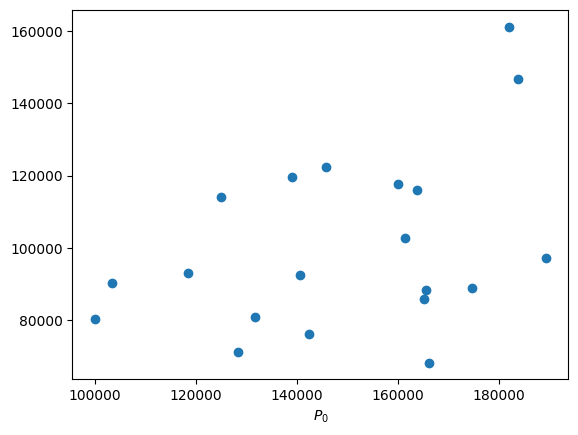

In [26]:
import matplotlib.pyplot as plt
plt.xlabel("$P_0\vspace[Pa]$")
plt.scatter(x=p0, y=p1)